<a href="https://colab.research.google.com/github/nahimaort/Traffic-Signs-Recognition/blob/main/TrafficSigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocedor de señales de tráfico

Vamos a desarrollar una red que reconozca señales de tráfico de tipo precaución.




In [1]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Vemos una imagen de ejemplo

Traffic-Signs  Traffic-Signs-2	Traffic-Signs-Validation


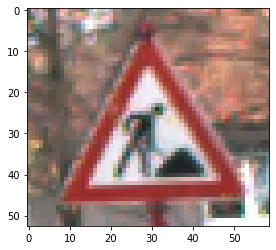

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs/5/00025_00040_00018.png', 'r')
imshow(np.asarray(pil_im))



## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import glob

datagen = ImageDataGenerator(
  horizontal_flip=False,
	vertical_flip=False,
	rotation_range=25,
	zoom_range=0.20,
	shear_range=0.20,
	fill_mode="nearest")

for i in range(1, 10, 1):
  for name in glob.glob("/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs/" + str(i) + "/*.png"):
    img = load_img(name)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 
    j = 0
    for batch in datagen.flow(x, batch_size=1,
                                  save_to_dir="/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs/" + str(i) + "/da/", 
                              save_prefix="image", save_format='png'):
      j += 1
      if j >= 2:
        break
print("Finalización del aumento de datos")

## Primer modelo

In [31]:
# DATA SOURCE --------------------------------------------------

image_size = (150, 150)
batch_size = 100

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs",
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs-Validation",
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4393 files belonging to 9 classes.
Found 360 files belonging to 9 classes.


In [32]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [34]:
# TRAINING --------------------------------------------------

epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/100
44/44 [==============================] - 16s 317ms/step - loss: 0.0525 - accuracy: 0.9822 - val_loss: 0.2166 - val_accuracy: 0.9472
Epoch 2/100
44/44 [==============================] - 16s 312ms/step - loss: 0.0429 - accuracy: 0.9847 - val_loss: 0.1590 - val_accuracy: 0.9556
Epoch 3/100
44/44 [==============================] - 16s 311ms/step - loss: 0.0502 - accuracy: 0.9795 - val_loss: 0.1749 - val_accuracy: 0.9500
Epoch 4/100
44/44 [==============================] - 16s 314ms/step - loss: 0.0501 - accuracy: 0.9816 - val_loss: 0.1722 - val_accuracy: 0.9611
Epoch 5/100
44/44 [==============================] - 16s 313ms/step - loss: 0.0521 - accuracy: 0.9822 - val_loss: 0.1703 - val_accuracy: 0.9556
Epoch 6/100
44/44 [==============================] - 16s 309ms/step - loss: 0.0471 - accuracy: 0.9836 - val_loss: 0.2011 - val_accuracy: 0.9583
Epoch 7/100
44/44 [==============================] - 16s 308ms/step - loss: 0.0457 - accuracy: 0.9841 - val_loss: 0.1310 - val_accuracy:

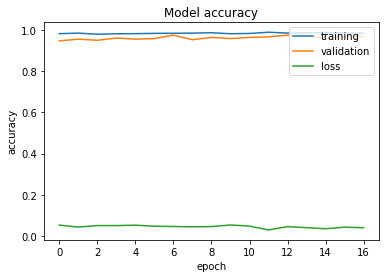

In [35]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.9750    1.0000    0.9873        39
           1     0.9750    0.8667    0.9176        45
           2     0.9250    1.0000    0.9610        37
           3     1.0000    1.0000    1.0000        40
           4     0.9250    1.0000    0.9610        37
           5     1.0000    1.0000    1.0000        40
           6     0.9750    1.0000    0.9873        39
           7     1.0000    1.0000    1.0000        40
           8     1.0000    0.9302    0.9639        43

    accuracy                         0.9750       360
   macro avg     0.9750    0.9774    0.9754       360
weighted avg     0.9760    0.9750    0.9746       360



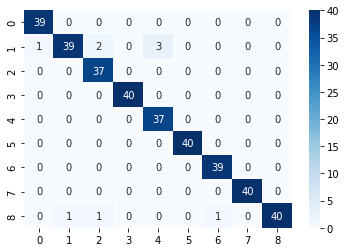

In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [37]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/Traffic-Signs/2/00021_00006_00000.png', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1


In [38]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/imagenes/imagen5.png', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

5
